Team members:
- Sophia Gabriela Martinez Albarran A01424430
- Eduardo Botello Casey A01659281
- Marcos Saade Romano A01784220

## Dataset description

The data is related with direct marketing campaigns (phone calls) of a Portuguese banking institution. The classification goal is to predict if the client will subscribe a term deposit (variable y). It contains 6 integers variables and 11 categorical variables. It has 45211 instances of data, where we will be performing a cleaning and preprocessing before creating the models.

In [1]:
import sklearn 
from ucimlrepo import fetch_ucirepo 
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVC

  
# https://archive.ics.uci.edu/dataset/222/bank+marketing  
# fetch dataset 
bank_marketing = fetch_ucirepo(id=222) 
  
# data (as pandas dataframes) 
X = bank_marketing.data.features 
y = bank_marketing.data.targets 
  
# Drop the column duration because in the page it says it isn't necessary for a predictive model
X = X.drop(columns=['duration'])

In [2]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   age          45211 non-null  int64 
 1   job          44923 non-null  object
 2   marital      45211 non-null  object
 3   education    43354 non-null  object
 4   default      45211 non-null  object
 5   balance      45211 non-null  int64 
 6   housing      45211 non-null  object
 7   loan         45211 non-null  object
 8   contact      32191 non-null  object
 9   day_of_week  45211 non-null  int64 
 10  month        45211 non-null  object
 11  campaign     45211 non-null  int64 
 12  pdays        45211 non-null  int64 
 13  previous     45211 non-null  int64 
 14  poutcome     8252 non-null   object
dtypes: int64(6), object(9)
memory usage: 5.2+ MB


In [3]:
X.describe()

,age,balance,day_of_week,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,63.000000,871.000000,275.000000


## Data preprocessing 

- **Dataset source**: [UCI Repository - Bank Marketing](https://archive.ics.uci.edu/dataset/222/bank+marketing)
- **Dropped Column**: duration was removed, as specified in the dataset documentation, since it is not suitable for predictive modeling.
- **Missing values**: 
    - job, education, and contact filled with 'unknown'.
    - poutcome filled with 'nonexistent'.

- **Preprocessing**:
    - Polynomial Features of degree 2 to capture some nonlinear relationships.
    - Converting the yes/no target into binary numeric values 1 and 0 respectively. This transformation was required to make the data compatible with scikit-learn classifiers, which expect numeric labels. This also formalizes the task as a binary classification problem.

- **Model preparation**:
    - Split the dataset into training (80%) and test (20%) subsets using train_test_split(). The stratify=y parameter was used to maintain the original proportion of classes in both sets, which is particularly important for imbalanced classification problems. Additionally, random_state=42 was used to ensure that the split is reproducible, making the results consistent across runs.



In [4]:
X.job = X.job.fillna('unknown')
X.education = X.education.fillna('unknown')
X.poutcome = X.poutcome.fillna('nonexistent')
X.contact = X.contact.fillna('unknown')


In [5]:
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(X.select_dtypes(include=['int64', 'float64']))

X_poly = pd.DataFrame(X_poly, columns=poly.get_feature_names_out(X.select_dtypes(include=['int64', 'float64']).columns))

X_categorical = X.select_dtypes(include=['object'])
X = pd.concat([X_categorical, X_poly], axis=1)

In [6]:
y = y['y'].map({'yes': 1, 'no': 0})

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Logistic Regression Classifier 

Logistic Regression is widely used for binary classification problems and serves as an interpretable and effective baseline.

### Advantages:

- Interpretability: The model's coefficients indicate the direction and strength of each feature’s influence on the prediction.

- Efficiency: Training and inference are fast, even with large datasets.

- Probabilistic Output: It provides confidence scores for predictions.

- Built-in Regularization: It supports L2 regularization to reduce overfitting.

### Disadvantages 

- Assumes a linear relationship between the input features and the log-odds of the outcome.

- Sensitive to feature scaling, requiring standardized numeric features.

- Not suitable for nonlinear relationships unless combined with feature engineering.

In [8]:

cat_col = X.select_dtypes(include='object').columns.tolist()
num_col = X.select_dtypes(exclude='object').columns.tolist()


categorical_transformer_lr = OneHotEncoder(handle_unknown='ignore')
numerical_transformer_lr = StandardScaler()

preprocessor_lr = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer_lr, cat_col),
        ('num', numerical_transformer_lr, num_col)
    ]
)

pipeline_lr = Pipeline(steps=[
    ('preprocessor', preprocessor_lr),
    ('classifier', LogisticRegression(max_iter=1000))
])


### Preprocessing Pipeline for Logistic Regression

To ensure proper and consistent preprocessing of both categorical and numerical variables, we created a structured pipeline using ColumnTransformer and Pipeline.  
This approach is modular, prevents data leakage, and is fully compatible with cross-validation and model tuning.

The pipeline automatically identifies:  
- Categorical columns: Those with object dtype, storing them in cat_col.  
- Numerical columns: Remaining columns, storing them in num_col.  

#### Key Steps in the Pipeline:

- **OneHotEncoder:**  
   Converts each categorical column into a set of binary columns (0 or 1), one for each category.  
   - Uses handle_unknown='ignore to safely handle unseen categories in new data.  

- **StandardScaler:**  
   Standardizes numerical features by removing the mean and scaling to unit variance.  

#### Why This Setup?  
We use this approach because Logistic Regression is sensitive to feature scaling. Standardized inputs for numerical features and encoded categorical variables are essential for optimal performance.

#### Building the Preprocessing Object:  
- The categorical_transformer applies the OneHotEncoder to the categorical columns.  
- The numerical_transformer applies the StandardScaler to the numeric columns.  




In [9]:
param = {
    'classifier__C': [0.01, 0.1, 1, 10],
    'classifier__penalty': ['l2'],
    'classifier__solver': ['lbfgs']
}

grid_search = GridSearchCV(pipeline_lr, param, cv=5, scoring='roc_auc')
grid_search.fit(X_train, y_train)

best_logisticreg_model = grid_search.best_estimator_

Hyperparameter tuning was performed using GridSearchCV with 5-fold cross-validation. A grid of candidate values was defined for C, the regularization strength of the Logistic Regression model. We fixed the penalty to L2 and used the lbfgs solver due to its efficiency with this penalty. The model was evaluated using the ROC AUC metric during cross-validation, which is appropriate for this imbalanced classification task. The best pipeline configuration was stored in best_logisticreg_model and used for final evaluation.

In [10]:
y_pred = best_logisticreg_model.predict(X_test)
y_proba = best_logisticreg_model.predict_proba(X_test)[:, 1]

print("Best parameters :", grid_search.best_params_)
print("Classification report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))


Best parameters : {'classifier__C': 0.1, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs'}
Classification report:
               precision    recall  f1-score   support

           0       0.90      0.99      0.94      7985
           1       0.66      0.17      0.27      1058

    accuracy                           0.89      9043
   macro avg       0.78      0.58      0.61      9043
weighted avg       0.87      0.89      0.86      9043

Confusion Matrix:
 [[7894   91]
 [ 880  178]]
ROC AUC: 0.772730770004723


The model achieves high precision (0.67) on the positive class (yes), meaning that when it predicts a client will subscribe, it is often correct.

However, it has low recall (0.17) on that same class, indicating that it misses a large portion of the actual positives.

The ROC AUC score of 0.77 indicates the model has a moderate ability to distinguish between the positive and negative classes.

This imbalance is common in datasets with skewed class distribution (most clients do not subscribe).

The high overall accuracy (0.89) is influenced by the model’s strong performance on the dominant class (no), but it may not be sufficient for applications where detecting potential subscribers is critical.'

It is important to consider the low amount of True Positives (class 1 predicted as class 1) and large amount of False Negatives (class 1 predicted as class 0), where in the context of the model it is pretty harmful to not predict correctly the costumers who would subscribe to the bank term deposit as they are the most important clients for the bank's success.

# Naive Bayes Classifier

Naive Bayes is a family of simple yet effective probabilistic classifiers based on applying Bayes' Theorem with a strong (naive) assumption of feature independence.

### Advantages:

- Fast and Scalable: Extremely efficient to train and predict, even on large datasets.

- Works Well with Categorical Data: Especially useful when features are categorical or count-based.

- Robust to Irrelevant Features: Performs reasonably well even when some features are not informative.

- Probabilistic Interpretation: Naturally provides class probabilities, useful for ranking or decision thresholds.

### Disadvantages:

- Strong Independence Assumption: Assumes that all features are conditionally independent given the class, which is often unrealistic.

- Limited Expressiveness: Performs poorly when there are complex feature interactions or nonlinear boundaries.

- Poor Probability Calibration: Predicted probabilities may be unreliable compared to logistic regression or tree-based models.

- Requires Careful Feature Encoding: Must choose the right variant (Gaussian, Multinomial, Bernoulli) depending on the data type.


In [11]:
cat_col = X.select_dtypes(include='object').columns.tolist()

categorical_transformer_nb = OneHotEncoder(handle_unknown='ignore', sparse_output=False)


preprocessor_nb = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer_nb, cat_col),
    ]
)

pipeline_nb = Pipeline(steps=[
    ('preprocessor', preprocessor_nb),
    ('classifier', GaussianNB())
])


### Pipeline for Naive Bayes Classifier

To preprocess the categorical variables and construct a pipeline for the Naive Bayes classifier, we used ColumnTransformer and Pipeline.  
This approach ensures modularity, prevents data leakage, and integrates seamlessly with cross-validation or model tuning workflows.

The pipeline automatically identifies categorical columns and stores them in cat_col. These columns are preprocessed to ensure compatibility with the Naive Bayes algorithm.

#### Key Steps in the Pipeline:

- **OneHotEncoder:**  
   Converts each categorical column into binary columns (0 or 1), ensuring numerical representation of the data.  
   - This transformation is necessary because Naive Bayes requires numeric input for its probabilistic calculations.  

- **ColumnTransformer:**  
   Applies the OneHotEncoder specifically to the identified categorical columns in cat_col. This step ensures that categorical data is properly encoded before being passed to the model.  

#### Why No Scaling?  
Scaling is not applied in this pipeline because the Naive Bayes algorithm does not rely on feature scales. Unlike algorithms sensitive to input magnitudes, Naive Bayes calculates probabilities directly and assumes independence between features.

#### Why This Setup?  
This setup guarantees that categorical features are transformed into a numerical format compatible with the Naive Bayes model while avoiding unnecessary preprocessing steps like scaling.  
By applying OneHotEncoder through ColumnTransformer, the pipeline remains modular and efficient, ensuring reliable integration with cross-validation and hyperparameter tuning.


In [12]:
param = {
    'classifier__priors': [None, [0.6, 0.4], [0.4, 0.6]],
    'classifier__var_smoothing': [1e-09, 1e-08, 1e-07],
}

grid_search = GridSearchCV(pipeline_nb, param, cv=5, scoring='roc_auc')
grid_search.fit(X_train, y_train)

best_gaussian_model = grid_search.best_estimator_

Hyperparameter tuning was performed using GridSearchCV with 5-fold cross-validation.

A grid of candidate values was defined for the priors, which represent the prior probabilities of the classes, and var_smoothing, a parameter that controls the variance smoothing to handle numerical stability in the Gaussian Naive Bayes model.

The model was evaluated using the ROC AUC metric during cross-validation, which is suitable for this imbalanced classification task. The best pipeline configuration was stored in best_gaussian_model and used for final evaluation.

In [13]:
y_pred = best_gaussian_model.predict(X_test)
y_proba = best_gaussian_model.predict_proba(X_test)[:, 1]

print("Best parameters :", grid_search.best_params_)
print("Classification report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))


Best parameters : {'classifier__priors': [0.4, 0.6], 'classifier__var_smoothing': 1e-09}
Classification report:
               precision    recall  f1-score   support

           0       0.93      0.86      0.90      7985
           1       0.33      0.53      0.41      1058

    accuracy                           0.82      9043
   macro avg       0.63      0.69      0.65      9043
weighted avg       0.86      0.82      0.84      9043

Confusion Matrix:
 [[6875 1110]
 [ 501  557]]
ROC AUC: 0.749277650793726


The model achieves low precision (0.33) on the positive class (1), meaning that when it predicts a positive class, it is often incorrect due to the low precision.

However, it has a slightly better recall (0.53) for the same class, indicating that it correctly identifies more than half of the actual positives.

The ROC AUC score of 0.75 suggests the model has a moderate ability to distinguish between the positive and negative classes overall, but there is still significant room for improvement.

The imbalance in performance is evident from the classification report and confusion matrix. The model performs well on the dominant class (class 0), achieving high precision and recall, but struggles with the minority class.

In this context, the relatively low True Positives (557 instances of class 1 correctly predicted) and large amount of False Negatives (501 instances of class 1 predicted as class 0) suggest that the model fails to identify many positive cases. In this context it is a big improvement from the Logistic Regression.

# Support Vetor Classifier, Eduardo

SVC is a supervised learning algorithm widely used for classification tasks, particularly effective for binary classification and high-dimensional data.

### Advantages:

- Effective in High-Dimensional Spaces: Performs well in datasets with many features.

- Clear Margin of Classification: Maximizes the margin between classes for better generalization.

- Flexibility : Provides flexibility to handle linear and non-linear relationships through the use of kernel functions.


### Disadvantages 

- Sensitive to feature scaling: Requiring steps like normalization or standardization in numeric features.

- Limited Interpretability: Unlike models like Logistic Regression, SVC does not provide coefficients or feature importance.

- Computationally expensive Memory and computation requirements increase significantly with dataset size.

In [14]:
categorical_features = X.select_dtypes(include=["object", "category"]).columns
numerical_features = X.select_dtypes(include=["int64", "float64"]).columns

categorical_transformer_sv = OneHotEncoder(handle_unknown="ignore")
numerical_transformer_sv = StandardScaler()


preprocessor_sv = ColumnTransformer(
    transformers=[
        ("num", numerical_transformer_sv, numerical_features),
        ("cat", categorical_transformer_sv, categorical_features),
    ]
)


pipeline_sv = Pipeline(steps=[
    ("preprocessor", preprocessor_sv),
    ("classifier", SVC(kernel="linear", class_weight="balanced"))
])



### Preprocessing Pipeline for SVC

To ensure proper and consistent preprocessing of both categorical and numerical variables, we created a structured pipeline using ColumnTransformer and Pipeline.  
This approach is modular, prevents data leakage, and is fully compatible with cross-validation and model tuning.

The pipeline automatically identifies:  
- **Categorical columns**: Those with object dtype, stored in categorical_features.  
- **Numerical columns**: Remaining columns, stored in numerical_features.  

#### Key Steps in the Pipeline:

- **OneHotEncoder:**  
   Converts each categorical column into a set of binary columns (0 or 1), one for each category.  
   - Uses handle_unknown='ignore' to safely handle unseen categories in new data.  

- **StandardScaler:**  
   Standardizes numerical features by removing the mean and scaling to unit variance.  

#### Why This Setup?  
We use this approach because SVC (Support Vector Classifier) is sensitive to feature scaling. Standardized numerical inputs and encoded categorical variables are essential for the model to perform well.

#### Building the Preprocessing Object:  
- The categorical_transformer applies the OneHotEncoder to the categorical columns.  
- The numerical_transformer applies the StandardScaler to the numerical columns.  


In [15]:
param_grid = {
    "classifier__C": [0.1, 1, 10],      
    "classifier__gamma": ["scale", "auto"]  
}


grid_search = GridSearchCV(pipeline_sv, param_grid, cv=3, scoring="f1")
grid_search.fit(X_train, y_train)
 

best_svc_model = grid_search.best_estimator_


Hyperparameter tuning was performed using GridSearchCV with 3-fold cross-validation, we chose 3 instead of 5 because of the time complexity of SVC.  

A grid of candidate values was defined for the hyperparameters of the SVC classifier within the pipeline:  
- C, the regularization parameter that controls the trade-off between achieving a low error on the training data and minimizing the model's complexity (values: 0.1, 1, 10).  
- gamma, which defines the influence of a single training example (values: "scale" and "auto").  

The model was evaluated using the F1 score during cross-validation, which is particularly useful for imbalanced datasets as it balances precision and recall. Roc auc is not used because SVC doesn't calculate probabilities as the other models do.

The best pipeline configuration was stored in best_svc_model and used for final evaluation.  


In [16]:
y_pred = best_svc_model.predict(X_test)

print("Best parameters :", grid_search.best_params_)
print("Classification report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("f1 Score:", f1_score(y_test, y_pred))


Best parameters : {'classifier__C': 0.1, 'classifier__gamma': 'scale'}
Classification report:
               precision    recall  f1-score   support

           0       0.93      0.82      0.88      7985
           1       0.30      0.56      0.39      1058

    accuracy                           0.79      9043
   macro avg       0.62      0.69      0.63      9043
weighted avg       0.86      0.79      0.82      9043

Confusion Matrix:
 [[6582 1403]
 [ 463  595]]
f1 Score: 0.3893979057591623


The model achieves high precision (0.93) on the negative class (0), meaning that when it predicts a client will not subscribe, it is often correct. However, for the positive class (1), the precision is much lower (0.30), indicating that many predicted subscribers are false positives.

The recall for the positive class (1) is moderate (0.56), suggesting that the model captures slightly more than half of the actual subscribers. However, the recall for the negative class (0) is strong (0.82), showing that it correctly identifies most non-subscribers.

The F1-score for the positive class (0.39) reflects the trade-off between precision and recall, highlighting the model’s difficulty in reliably identifying subscribers. The overall accuracy (0.79) is influenced by the model’s performance on the dominant class (0), but this may not be sufficient for applications where detecting potential subscribers is critical.

The confusion matrix reveals a significant number of False Negatives (463), where actual subscribers were incorrectly predicted as non-subscribers. This is particularly harmful in the context of banking, as failing to identify potential clients who would subscribe to the term deposit can negatively impact the bank’s success.

The class imbalance (with class 0 being much larger than class 1) likely contributes to these results, as the model may be biased toward predicting the majority class.

# Desition Tree classifier

### Advantages:

- Handles Nonlinear Relationships: Decision Trees can model complex, nonlinear relationships between features and the target variable.

- Interpretability: The tree structure is easy to visualize and interpret, making it accessible to non-technical stakeholders.

- No Need for Feature Scaling: Decision Trees do not require normalization or standardization of features.

- Handles Both Categorical and Numerical Data: Can process mixed data types without requiring extensive preprocessing.

- Robust to Outliers: Less sensitive to outliers compared to linear models.

### Disadvantages:

- Overfitting: Decision Trees are prone to overfitting, especially when they grow deep.

- Instability: Small changes in the data can lead to significantly different tree structures.

- Bias Towards Dominant Classes: In imbalanced datasets, the tree may favor the majority class.

- Limited Generalization: Without pruning or regularization, the model may not generalize well to unseen data.

- Computationally Expensive: Training can be slow for large datasets with many features.

In [17]:
from sklearn.tree import DecisionTreeClassifier

cat_col = X.select_dtypes(include='object').columns.tolist()

categorical_transformer_dt = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

preprocessor_dt = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer_dt, cat_col),
    ]
)

pipeline_dt = Pipeline(steps=[
    ('preprocessor', preprocessor_dt),
    ('classifier', DecisionTreeClassifier(random_state=42))
])


### Preprocessing Pipeline for Decision Tree Classifier

The pipeline for the Decision Tree classifier was constructed using Pipeline and ColumnTransformer to preprocess the categorical variables.

- **Categorical Columns:**  
  The categorical columns (cat_col) were identified as those with object dtype.

- **OneHotEncoder:**  
  A OneHotEncoder was applied to these columns to convert them into binary features.  
  This ensures that the categorical data is represented numerically, which is required for the Decision Tree algorithm.

- **ColumnTransformer:**  
  The ColumnTransformer applies the OneHotEncoder to the categorical columns.

### Why Not Scaling?

Unlike many other machine learning algorithms, Decision Trees are not sensitive to feature scaling.  
This simplifies the preprocessing pipeline by only requiring encoding of categorical variables.

### Why This Setup?

This setup ensures that categorical features are properly encoded into a numerical format that the Decision Tree can process.  
By applying OneHotEncoder through ColumnTransformer, the pipeline handles all categorical columns efficiently and safely, making it modular and compatible with cross-validation and model tuning.


In [18]:
param = {
    'classifier__criterion': ['gini', 'entropy'],
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(pipeline_dt, param, cv=5, scoring='roc_auc')
grid_search.fit(X_train, y_train)

best_decision_tree_model = grid_search.best_estimator_

Hyperparameter tuning was performed using GridSearchCV with 5-fold cross-validation.

A grid of candidate values was defined for the criterion, which determines the function to measure the quality of a split (e.g., 'gini' or 'entropy'), max_depth, which limits the depth of the tree to prevent overfitting, min_samples_split, the minimum number of samples required to split an internal node, and min_samples_leaf, the minimum number of samples required to be at a leaf node.

The model was evaluated using the ROC AUC metric during cross-validation, which is appropriate for imbalanced classification tasks. The best pipeline configuration was stored in best_decision_tree_model and used for final evaluation.

In [19]:
y_pred = best_decision_tree_model.predict(X_test)
y_proba = best_decision_tree_model.predict_proba(X_test)[:, 1]

print("Best parameters :", grid_search.best_params_)
print("Classification report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))


Best parameters : {'classifier__criterion': 'entropy', 'classifier__max_depth': 10, 'classifier__min_samples_leaf': 4, 'classifier__min_samples_split': 10}
Classification report:
               precision    recall  f1-score   support

           0       0.90      0.99      0.94      7985
           1       0.61      0.17      0.27      1058

    accuracy                           0.89      9043
   macro avg       0.76      0.58      0.60      9043
weighted avg       0.87      0.89      0.86      9043

Confusion Matrix:
 [[7871  114]
 [ 878  180]]
ROC AUC: 0.7594911536635919


The model achieves high precision (0.90) and near-perfect recall (0.99) on the negative class (0), meaning it is extremely reliable at predicting non-subscribers and rarely misses them. However, for the positive class (1), the precision is moderate (0.61), but the recall is very low (0.17), indicating that while the model is somewhat correct when it predicts a subscriber, it misses the vast majority (83%) of actual subscribers.

The F1-score for the positive class (0.27) is poor, reflecting the model’s struggle to balance precision and recall for the minority class. The overall accuracy (0.89) is high, but this is largely driven by the model’s strong performance on the dominant class (0), which makes up most of the dataset.

The confusion matrix reveals:

- 878 False Negatives (FN): Actual subscribers wrongly predicted as non-subscribers.
- 180 True Positives (TP): Correctly identified subscribers.

The high number of False Negatives (878) is particularly concerning in a banking context, as failing to identify potential subscribers directly impacts revenue opportunities.

The ROC AUC score (0.76) suggests the model has a moderate ability to distinguish between subscribers and non-subscribers, but its performance is skewed by class imbalance.

In [22]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "decision_trees"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [25]:

from sklearn.tree import export_graphviz
tree = best_decision_tree_model.named_steps['classifier']
feature_names = best_decision_tree_model.named_steps['preprocessor'].get_feature_names_out()

export_graphviz(
        tree,
        out_file=str(IMAGES_PATH / "class_tree.dot"),  # path differs in the book
        feature_names=feature_names,
        class_names=[str(cls) for cls in tree.classes_],
        rounded=True,
        filled=True
)

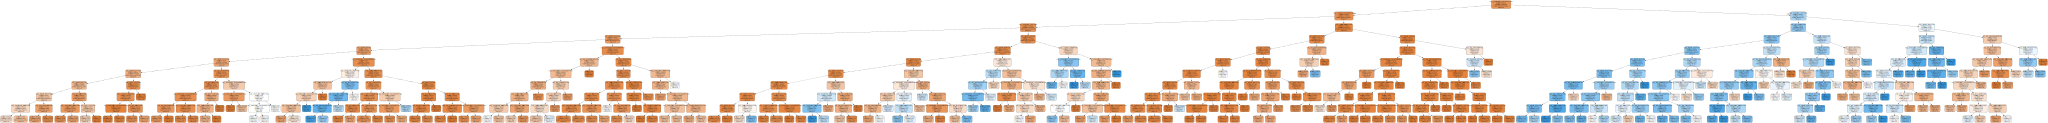

In [26]:

from graphviz import Source

Source.from_file(IMAGES_PATH / "class_tree.dot")  # path differs in the book

# Ensemble
We are going to train some ensemble models, and compare their performance to the baseline models.

In [20]:
from sklearn.ensemble import VotingClassifier

# Define the ensemble models
hard_voting_ensemble = VotingClassifier(
    estimators=[
        ('logistic', best_logisticreg_model),
        ('gaussian', best_gaussian_model),
        ('vector_machine', best_svc_model),
        ('decision_tree', best_decision_tree_model)
    ],
    voting='hard'
)

soft_voting_ensemble = VotingClassifier(
    estimators=[
        ('logistic', best_logisticreg_model),
        ('gaussian', best_gaussian_model),
        ('decision_tree', best_decision_tree_model)
    ],
    voting='soft'
)

# Train the hard voting ensemble
hard_voting_ensemble.fit(X_train, y_train)

# Train the soft voting ensemble
soft_voting_ensemble.fit(X_train, y_train)

,estimators,"[('logistic', ...), ('gaussian', ...), ...]"
,voting,'soft'
,weights,None
,n_jobs,None
,flatten_transform,True
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None


In the cell above, we define and train two ensemble models using the VotingClassifier from scikit-learn. The first model, hard_voting_ensemble, uses hard voting, where the final prediction is based on the majority vote of the individual classifiers. The second model, soft_voting_ensemble, uses soft voting, where the final prediction is based on the average of the predicted probabilities from the individual classifiers.

Hard voting combines four base models: the logistic regression model (best_logisticreg_model), the Gaussian Naive Bayes model (best_gaussian_model), the Support Vector Classificator (best_svc_model), and the decision tree model (best_decision_tree_model). 

While soft voting combines three base models: the logistic regression model (best_logisticreg_model), the Gaussian Naive Bayes model (best_gaussian_model) and the decision tree model (best_decision_tree_model). The reason for the exclusion of SVC in soft is because SVC doesn't generates probabilities for predictions and soft voting needs them to work.

After defining the ensembles, we fit them to the training data (X_train and y_train) to prepare them for evaluation.

# Model evaluation

## Training set

In [27]:
# Hard voting ensemble on training set
y_pred_hard_train = hard_voting_ensemble.predict(X_train)

print("Hard Voting Ensemble - Training Set:")
print("Classification Report:\n", classification_report(y_train, y_pred_hard_train))
print("Confusion Matrix:\n", confusion_matrix(y_train, y_pred_hard_train))

# Soft voting ensemble on training set
y_pred_soft_train = soft_voting_ensemble.predict(X_train)
y_proba_soft_train = soft_voting_ensemble.predict_proba(X_train)[:, 1]

print("\nSoft Voting Ensemble - Training Set:")
print("Classification Report:\n", classification_report(y_train, y_pred_soft_train))
print("Confusion Matrix:\n", confusion_matrix(y_train, y_pred_soft_train))
print("ROC AUC:", roc_auc_score(y_train, y_proba_soft_train))

# Compare with baseline models on training set
print("\nBaseline Models Comparison - Training Set:")

# Logistic Regression
y_pred_lr_train = best_logisticreg_model.predict(X_train)
y_proba_lr_train = best_logisticreg_model.predict_proba(X_train)[:, 1]
print("\nLogistic Regression - Training Set:")
print("Classification Report:\n", classification_report(y_train, y_pred_lr_train))
print("Confusion Matrix:\n", confusion_matrix(y_train, y_pred_lr_train))
print("ROC AUC:", roc_auc_score(y_train, y_proba_lr_train))

# Gaussian Naive Bayes
y_pred_gaussian_train = best_gaussian_model.predict(X_train)
y_proba_gaussian_train = best_gaussian_model.predict_proba(X_train)[:, 1]
print("\nGaussian Naive Bayes - Training Set:")
print("Classification Report:\n", classification_report(y_train, y_pred_gaussian_train))
print("Confusion Matrix:\n", confusion_matrix(y_train, y_pred_gaussian_train))
print("ROC AUC:", roc_auc_score(y_train, y_proba_gaussian_train))

# Support Vector Machine
y_pred_svc_train = best_svc_model.predict(X_train)
print("\nSupport Vector Machine - Training Set:")
print("Classification Report:\n", classification_report(y_train, y_pred_svc_train))
print("Confusion Matrix:\n", confusion_matrix(y_train, y_pred_svc_train))

# Decision Tree
y_pred_tree_train = best_decision_tree_model.predict(X_train)
y_proba_tree_train = best_decision_tree_model.predict_proba(X_train)[:, 1]
print("\nDecision Tree - Training Set:")
print("Classification Report:\n", classification_report(y_train, y_pred_tree_train))
print("Confusion Matrix:\n", confusion_matrix(y_train, y_pred_tree_train))
print("ROC AUC:", roc_auc_score(y_train, y_proba_tree_train))


Hard Voting Ensemble - Training Set:
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.99      0.94     31937
           1       0.66      0.22      0.32      4231

    accuracy                           0.90     36168
   macro avg       0.78      0.60      0.63     36168
weighted avg       0.88      0.90      0.87     36168

Confusion Matrix:
 [[31467   470]
 [ 3321   910]]

Soft Voting Ensemble - Training Set:
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.95      0.94     31937
           1       0.52      0.38      0.44      4231

    accuracy                           0.89     36168
   macro avg       0.72      0.67      0.69     36168
weighted avg       0.87      0.89      0.88     36168

Confusion Matrix:
 [[30415  1522]
 [ 2612  1619]]
ROC AUC: 0.7736095555709799

Baseline Models Comparison - Training Set:

Logistic Regression - Training Set:
Classification

### Hard voting 

It demonstrates strong performance for class 0 with high precision (0.90) and near-perfect recall (0.99), resulting in an excellent F1-score of 0.94. For class 1, precision is moderate at 0.66, but recall drops significantly to 0.22, giving a much lower F1-score of 0.32.

The model achieves an overall accuracy of 0.90, with macro averages of 0.78 precision, 0.60 recall, and 0.63 F1-score. The weighted averages are higher at 0.88, 0.90, and 0.87 respectively, reflecting the dominance of class 0 which represents 88% of the dataset.

The confusion matrix reveals:

- 910 true positives (correct class 1 predictions)
- 3,321 false negatives (class 1 misclassified as class 0)

It represents that from the 4231 clients who subscribed, the model only correctly identified 21% of such clients making it not very optimal for the task.

The model shows excellent performance on the majority class but limited ability to identify the minority class, as evidenced by the low recall (0.22) and high false negatives (3,321) for class 1. The precision for class 1 (0.66) suggests that when the model does predict class 1, it is correct about two-thirds of the time.

### Soft voting 

The soft voting ensemble shows high precision (0.92) and recall (0.95) for class 0, resulting in a strong F1-score of 0.94. For class 1, precision is 0.52 while recall stands at 0.38, producing a modest F1-score of 0.44. The overall accuracy is 0.89, with macro averages of 0.72 precision, 0.67 recall, and 0.69 F1-score.

The confusion matrix reveals 30,415 true negatives and 1,619 true positives, with 1,522 false positives and 2,612 false negatives. Compared to the hard voting ensemble, this soft voting approach shows:

- Lower precision for class 1 (0.52 vs 0.66)

- Better recall for class 1 (0.38 vs 0.22)

- More balanced performance between classes

- Increased true positives (1,619 vs 910)

- Reduced false negatives (2,612 vs 3,321)

The ROC AUC score of 0.77 indicates moderate discrimination capability between the classes. The weighted averages (0.87 precision, 0.89 recall, 0.88 F1-score) reflect the model's stronger performance on the majority class while showing some improvement in minority class detection compared to the hard voting approach.


### Logistic Regression

The  model demonstrates excellent performance for class 0 with high precision (0.90) and near-perfect recall (0.99), giving a strong F1-score of 0.94. For class 1, while precision is relatively good at 0.67, the recall drops sharply to 0.17, resulting in a weak F1-score of 0.27.

The model achieves an overall accuracy of 0.89. The macro averages show moderate performance (0.78 precision, 0.58 recall, 0.61 F1-score), while the weighted averages are higher (0.87 precision, 0.89 recall, 0.86 F1-score), reflecting the model's bias toward the majority class.

The confusion matrix reveals:

- 718 true positives (correct class 1 predictions)

- 3,513 false negatives (class 1 misclassified as class 0)

It represents that from the 4231 clients who subscribed, the model only correctly identified 17% of such clients making it very bad for the bank objectives.

The ROC AUC score of 0.77 indicates the model has moderate ability to distinguish between the two classes. The particularly low recall (0.17) for class 1 suggests the model struggles to identify positive cases, missing 83% of actual class 1 instances despite its reasonable precision when it does predict this class.

### Naive Bayes

The  model shows good precision (0.93) but slightly lower recall (0.86) for class 0, resulting in an F1-score of 0.89. For class 1, precision is low at 0.32 while recall is better at 0.50, producing an F1-score of 0.39. The overall accuracy is 0.82.

The confusion matrix reveals:

- 2,133 true positives (correct class 1 predictions)
- 2,098 false negatives (class 1 misclassified as class 0)

It is a huge improvement from the past models where from 4231 clients who subscribed, the model correctly identified 50% of such clients making it better for the bank metrics.

The ROC AUC score of 0.74 indicates the model has moderate discrimination ability between classes. The model shows better recall but worse precision for class 1 compared to the logistic regression model, suggesting a different trade-off between these metrics.

### Support Vector Classifier

The model demonstrates a distinct performance pattern between the two classes. For class 0 (majority class), it achieves high precision (0.93) but more moderate recall (0.82), resulting in a solid F1-score of 0.87. The model shows the opposite behavior for class 1 (minority class), with relatively low precision (0.29) but better recall (0.57), producing an F1-score of 0.39.

The confusion matrix reveals the model makes 26,161 correct predictions for class 0 and identifies 2,395 true positives for class 1. However, it generates a substantial number of false positives (5,776) while maintaining a relatively lower count of false negatives (1,836). This pattern indicates the model is more aggressive in predicting the positive class, successfully capturing more actual positives but at the cost of reduced precision.

With an overall accuracy of 0.79, the model shows moderate performance that varies significantly between classes. The macro averages (0.61 precision, 0.69 recall) and weighted averages (0.86 precision, 0.79 recall) highlight this disparity, where the model's effectiveness differs markedly depending on which class it's evaluating. The trade-off between precision and recall is particularly evident in the minority class performance.

### Decision trees

The model shows excellent performance for class 0 with high precision (0.90) and near-perfect recall (0.99), resulting in a strong F1-score of 0.94. For class 1, while precision is relatively good at 0.71, the recall drops significantly to 0.20, resulting in a F1-score of 0.31. This creates a substantial performance gap between the two classes.

The model achieves an overall accuracy of 0.90, with macro averages of 0.81 precision, 0.59 recall, and 0.63 F1-score. The weighted averages are higher at 0.88 precision, 0.90 recall, and 0.87 F1-score, reflecting the model's strong performance on the majority class which dominates the dataset.

The confusion matrix reveals:
- 836 true positives (correct class 1 predictions)
- 3,395 false negatives (class 1 misclassified as class 0)

It means from 4231 clients who subscribed, the model correctly identified 19% of such clients making it less optimal for the task.

The ROC AUC score of 0.78 indicates moderate discrimination ability between the classes. The particularly low recall (0.20) for class 1 means the model fails to identify 80% of actual positive cases, despite its reasonable precision when it does predict this class. The high number of false negatives (3,395) suggests the model is heavily biased toward predicting the majority class.

## Test set

In [28]:
# Hard voting ensemble
y_pred_hard = hard_voting_ensemble.predict(X_test)

print("Hard Voting Ensemble:")
print("Classification Report:\n", classification_report(y_test, y_pred_hard))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_hard))

# Soft voting ensemble
y_pred_soft = soft_voting_ensemble.predict(X_test)
y_proba_soft = soft_voting_ensemble.predict_proba(X_test)[:, 1]

print("\nSoft Voting Ensemble:")
print("Classification Report:\n", classification_report(y_test, y_pred_soft))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_soft))
print("ROC AUC:", roc_auc_score(y_test, y_proba_soft))

# Baseline models
print("\nBaseline Models Comparison:")

# Logistic Regression
print("\nLogistic Regression:")
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

# Gaussian Naive Bayes
y_pred_gaussian = best_gaussian_model.predict(X_test)
y_proba_gaussian = best_gaussian_model.predict_proba(X_test)[:, 1]
print("\nGaussian Naive Bayes:")
print("Classification Report:\n", classification_report(y_test, y_pred_gaussian))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_gaussian))
print("ROC AUC:", roc_auc_score(y_test, y_proba_gaussian))

# Support Vector Machine
y_pred_svc = best_svc_model.predict(X_test)
print("\nSupport Vector Machine:")
print("Classification Report:\n", classification_report(y_test, y_pred_svc))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_svc))

# Decision Tree
y_pred_tree = best_decision_tree_model.predict(X_test)
y_proba_tree = best_decision_tree_model.predict_proba(X_test)[:, 1]
print("\nDecision Tree:")
print("Classification Report:\n", classification_report(y_test, y_pred_tree))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_tree))
print("ROC AUC:", roc_auc_score(y_test, y_proba_tree))


Hard Voting Ensemble:
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.98      0.94      7985
           1       0.64      0.21      0.31      1058

    accuracy                           0.89      9043
   macro avg       0.77      0.60      0.63      9043
weighted avg       0.87      0.89      0.87      9043

Confusion Matrix:
 [[7861  124]
 [ 839  219]]

Soft Voting Ensemble:
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.95      0.94      7985
           1       0.52      0.37      0.44      1058

    accuracy                           0.89      9043
   macro avg       0.72      0.66      0.69      9043
weighted avg       0.87      0.89      0.88      9043

Confusion Matrix:
 [[7625  360]
 [ 663  395]]
ROC AUC: 0.7772201658828641

Baseline Models Comparison:

Logistic Regression:
Classification Report:
               precision    recall  f1-score   support

   

### Hard voting 

The model achieves excellent precision (0.90) on the negative class (0), indicating strong reliability when predicting that a client will not subscribe. For the positive class (1), precision drops to 0.64, meaning about one-third of predicted subscribers are actually non-subscribers. While this moderate precision suggests some predictive value, the extremely low recall (0.21) reveals the model fails to identify 79% of actual subscribers.

The F1-score of 0.31 for the positive class underscores the model's poor balance between precision and recall when identifying subscribers. 

The confusion matrix shows 839 false negatives, where genuine subscribers were incorrectly classified as non-subscribers. In banking terms, this means hundreds of potential customers who would subscribe to term deposits are being overlooked, directly impacting revenue generation.

These results clearly stem from severe class imbalance, with the model biased toward the majority non-subscriber class. While it excels at identifying non-subscribers with 98% recall, this strength comes at the cost of missing most actual subscribers. 

### Soft voting 

The soft voting ensemble achieves high precision (0.92) and recall (0.95) for class 0, indicating strong performance in identifying negative cases. For class 1, precision drops to 0.52 while recall falls to 0.37, showing significantly weaker performance on the positive class. The F1-score of 0.44 for class 1 reflects this imbalance between precision and recall.

The model maintains an overall accuracy of 0.89, with macro averages of 0.72 for precision, 0.66 for recall, and 0.69 for F1-score. The weighted averages are higher at 0.87, 0.89, and 0.88 respectively, reflecting the influence of the majority class.

The ROC AUC score of 0.78 indicates moderate discrimination ability between the classes.

The confusion matrix shows 7625 true negatives and 395 true positives, with 300 false positives and 663 false negatives. It isn't perfect, but an upgrade from the hard voting ensemble.


### Logistic Regression

The model achieves high precision (0.67) on the positive class (yes), meaning that when it predicts a client will subscribe, it is often correct. However, it has low recall (0.17) on that same class, indicating that it misses a large portion of the actual positives (83%).

The ROC AUC score of 0.77 indicates the model has a moderate ability to distinguish between the positive and negative classes.

This imbalance is common in datasets with skewed class distribution (most clients do not subscribe).

The high overall accuracy (0.89) is influenced by the model’s strong performance on the dominant class (no), but it may not be sufficient for applications where detecting potential subscribers is critical.'

It is important to consider the low amount of True Positives (class 1 predicted as class 1) and large amount of False Negatives (class 1 predicted as class 0), where in the context of the model it is pretty harmful to not predict correctly the costumers who would subscribe to the bank term deposit as they are the most important clients for the bank's success.

### Naive Bayes

The model achieves low precision (0.33) on the positive class (1), meaning that when it predicts a positive class, it is often incorrect due to the low precision.

However, it has a slightly better recall (0.53) for the same class, indicating that it correctly identifies more than half of the actual positives.

The ROC AUC score of 0.75 suggests the model has a moderate ability to distinguish between the positive and negative classes overall, but there is still significant room for improvement.

The imbalance in performance is evident from the classification report and confusion matrix. The model performs well on the dominant class (class 0), achieving high precision and recall, but struggles with the minority class.

In this context, the relatively low True Positives (557 instances of class 1 correctly predicted) and large amount of False Negatives (501 instances of class 1 predicted as class 0) suggest that the model fails to identify many positive cases. In this context it is a big improvement from the Logistic Regression.

### Super Vector Classifier

The model achieves high precision (0.93) on the negative class (0), meaning that when it predicts a client will not subscribe, it is often correct. However, for the positive class (1), the precision is much lower (0.30), indicating that many predicted subscribers are false positives.

The recall for the positive class (1) is moderate (0.56), suggesting that the model captures slightly more than half of the actual subscribers. However, the recall for the negative class (0) is strong (0.82), showing that it correctly identifies most non-subscribers.

The F1-score for the positive class (0.39) reflects the trade-off between precision and recall, highlighting the model’s difficulty in reliably identifying subscribers. The overall accuracy (0.79) is influenced by the model’s performance on the dominant class (0), but this may not be sufficient for applications where detecting potential subscribers is critical.

The confusion matrix reveals a significant number of False Negatives (463), where actual subscribers were incorrectly predicted as non-subscribers. This is particularly harmful in the context of banking, as failing to identify potential clients who would subscribe to the term deposit can negatively impact the bank’s success.

The class imbalance (with class 0 being much larger than class 1) likely contributes to these results, as the model may be biased toward predicting the majority class.

### Decision trees

The model achieves high precision (0.90) and near-perfect recall (0.99) on the negative class (0), meaning it is extremely reliable at predicting non-subscribers and rarely misses them. However, for the positive class (1), the precision is moderate (0.61), but the recall is very low (0.17), indicating that while the model is somewhat correct when it predicts a subscriber, it misses the vast majority (83%) of actual subscribers.

The F1-score for the positive class (0.27) is poor, reflecting the model’s struggle to balance precision and recall for the minority class. The overall accuracy (0.89) is high, but this is largely driven by the model’s strong performance on the dominant class (0), which makes up most of the dataset.

The confusion matrix reveals:

- 878 False Negatives (FN): Actual subscribers wrongly predicted as non-subscribers.
- 180 True Positives (TP): Correctly identified subscribers.

The high number of False Negatives (878) is particularly concerning in a banking context, as failing to identify potential subscribers directly impacts revenue opportunities.

The ROC AUC score (0.76) suggests the model has a moderate ability to distinguish between subscribers and non-subscribers, but its performance is skewed by class imbalance.

# Conclusion

In this report, we explored various machine learning models to predict whether a client will subscribe to a term deposit based on the Bank Marketing dataset. The workflow included data preprocessing, model training, hyperparameter tuning, and evaluation.

### Key Findings:
1. **Baseline Models**:
    - Logistic Regression provided interpretable results and achieved a good balance between precision and recall. Great ammount of False Negatives while little of True Positives.
    - Gaussian Naive Bayes: was efficient but struggled with the dataset's feature dependencies. Had a great ratio of True Positives vs False Negatives similar to SVC.
    - Support Vector Classifier: best ratio of True Positives vs False Negatives but less precision in the positive class, took 74 minutes to train while other models did training in less than  minutes.
    - Decision Tree captured complex patterns but was prone to overfitting without proper regularization.  Great ammount of False Negatives while little of True Positives.

2. **Ensemble Models**:
    - The VotingClassifier ensembles (hard and soft voting) combined the strengths of individual models, leading to improved performance.
    - Soft voting, which averages predicted probabilities, demonstrated better scores in the True Positives vs False Negatives ratio compared to hard voting.

3. **Evaluation Metrics**:
    - While accuracy was high across models, it was influenced by the imbalanced nature of the dataset.
    - ROC AUC was a more reliable metric, highlighting the models' ability to distinguish between classes.
    - F1 score was a great metric because it balances precision and recall, making it particularly suitable for scenarios with class imbalance.

### Recommendations:
- For practical deployment, the soft voting ensemble is recommended due to its superior performance and robustness.
- If choosing a single model, Naive Bayes is recommended as it has similar results as SVC but with less training time and computational power.
- Further improvements could be achieved by exploring additional ensemble techniques (e.g., Random Forest, Gradient Boosting) and adding polynomial features.

This analysis demonstrates the importance of combining domain knowledge, data preprocessing, and model selection to achieve reliable predictions in real-world applications.